<a href="https://colab.research.google.com/github/icarocarmona/Tech-Challenges-DTAT-Grupo-26/blob/main/Tech_BVSP_Fase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prevendo valores de ações com algoritmos de machine learning e deep learning 🎯´



In [1]:
# Bibliotecas básicas de data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

# Para baixar os dados
import yfinance as yf


#Para aplicar o ARIMA:
from statsmodels.tsa.stattools import adfuller          #verificar dados estacionários
from statsmodels.tsa.stattools import acf, pacf         #correlação
from statsmodels.tsa.seasonal import seasonal_decompose #Decomposição sazonal usando médias móveis.
from statsmodels.tsa.arima.model import ARIMA           #algoritmo arima

# Para deep learning
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator

# Para machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Prophet
from prophet import Prophet

Upload do dataframe Bolsa

In [2]:
# Especifique o símbolo da Bolsa ^BVSP e o intervalo de datas desejado
symbol = '^BVSP'
start_date = '2018-01-01'
end_date = '2024-01-20'

# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,76403.0,77909.0,76403.0,77891.0,77891.0,2880300
1,2018-01-03,77889.0,78414.0,77602.0,77995.0,77995.0,3142200
2,2018-01-04,77998.0,79135.0,77998.0,78647.0,78647.0,3486100
3,2018-01-05,78644.0,79071.0,78218.0,79071.0,79071.0,2747100
4,2018-01-08,79070.0,79395.0,78631.0,79379.0,79379.0,2550800


In [4]:
df.shape #analisando linhas e colunas

(1500, 7)

In [5]:
df_bolsa = df # criando cópia do dataset

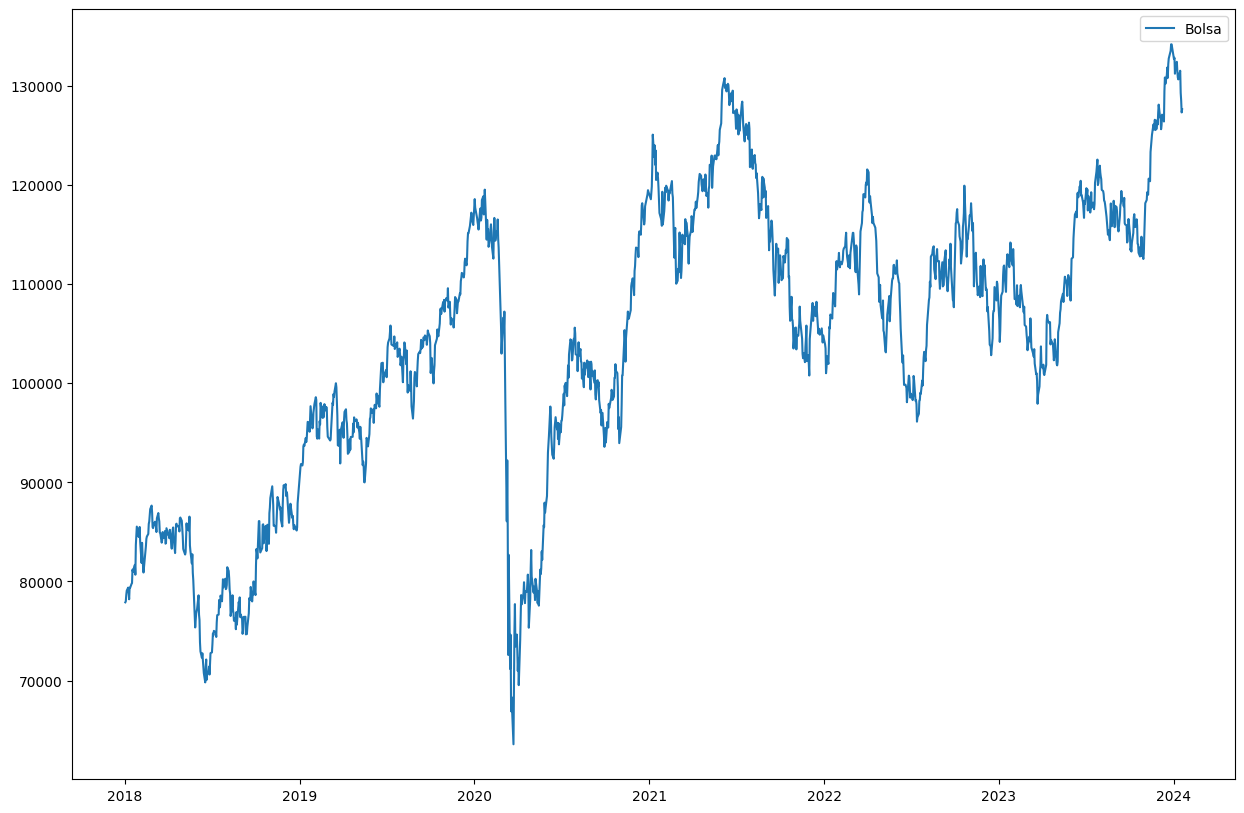

In [6]:
plt.figure(figsize = (15,10))
plt.plot(df['Date'], df['Close'], label='Bolsa')

plt.legend(loc='best')
plt.show()

# Análise de série temporal (Decomposição)
Utilizamos o Statsmodel para decompor nossos dados e visualizar vários gráficos.


**Tendência**
Direcionamento de sua série temporal (para qual direção ela está indo).

**Sazonalidade**
Encontrar caracteristicas e padrões no tempo que podem aparecer de forma repetida.

**Ruído**
Após extrair a tendência e a sazonalidade da série original, o que resta é chamado de resíduo. Os resíduos são a diferença entre a série original e o que foi explicado pela tendência e sazonalidade.

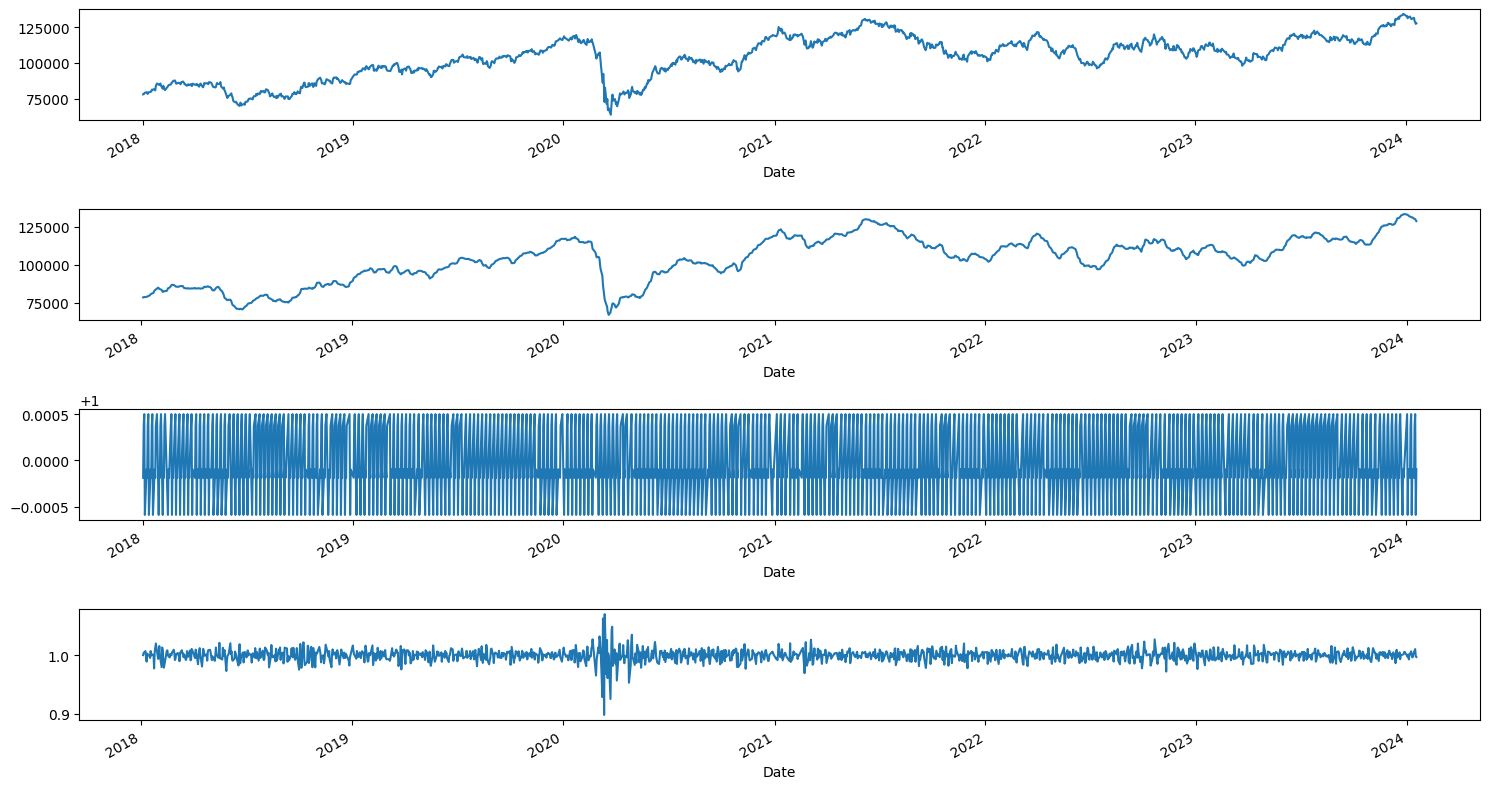

In [18]:

# Aqui a decomposição foi realizada no Data Frame inteiro de 2018 a 2024


from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df_limpo = df                                                              # cópia do dataframe
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])                        # transformando em datetime
df_limpo = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']) # Removendo colunas desnecessárias
df_limpo = df_limpo.set_index('Date')                                      # definindo data como índice

################################## Notas da análise de decomposição da série ########################################

# model='additive': Este parâmetro especifica o tipo de modelo utilizado na decomposição.

# Os dois tipos principais são:

# "additive" (modelo apropriado quando a magnitude da sazonalidade não varia com a tendência)
# "multiplicative" (modelo é mais apropriado quando a magnitude da sazonalidade varia com a tendência).

# period: Este é o período da sazonalidade. Ele especifica o número de observações em um ciclo sazonal.

######################################################################################################################

seasonplot = seasonal_decompose(df_limpo, model='multiplicative', period=5) #decopondo a série temporal
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1) #serie real
seasonplot.trend.plot(ax=ax2)    #tendencia
seasonplot.seasonal.plot(ax=ax3) #sazonalidade
seasonplot.resid.plot(ax=ax4)    #residuos
plt.tight_layout()

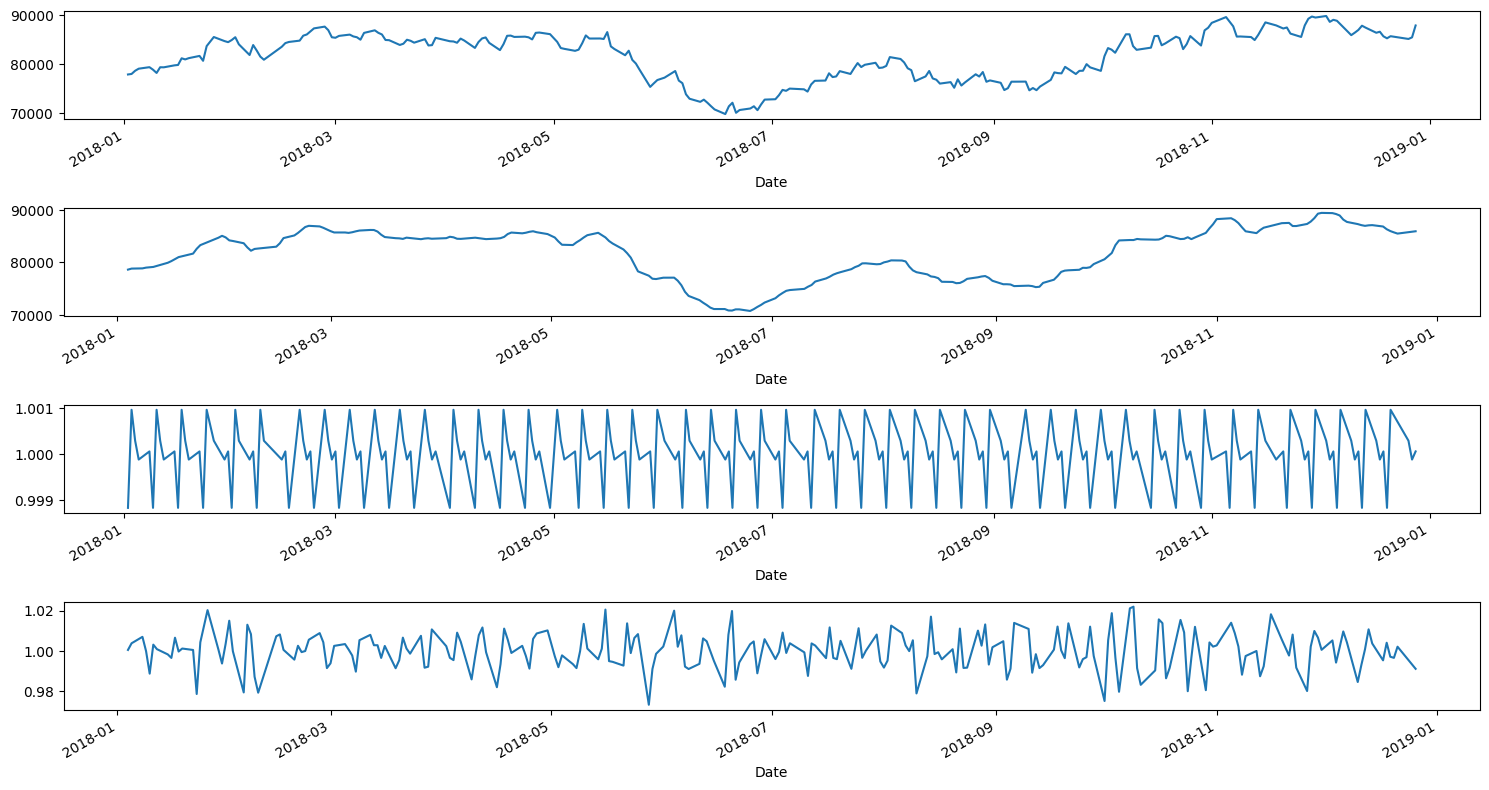

In [9]:

# Aqui a decomposição foi realizada no ano de 2018

df_limpo = df.copy()  # cópia do dataframe
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])  # transformando em datetime
df_limpo = df_limpo.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'])  # Removendo colunas desnecessárias
df_limpo = df_limpo.set_index('Date')  # definindo data como índice

# Filtrando por datas desejadas (por exemplo, de '2022-01-01' a '2022-12-31')
data_inicio = '2018-01-01'
data_fim = '2018-12-31'
df_limpo_filtrado = df_limpo.loc[data_inicio:data_fim]

# Decomposição sazonal nos dados filtrados
seasonplot = seasonal_decompose(df_limpo_filtrado, model='multiplicative', period=5)

# Subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8))
seasonplot.observed.plot(ax=ax1)  # Série real
seasonplot.trend.plot(ax=ax2)     # Tendência
seasonplot.seasonal.plot(ax=ax3)  # Sazonalidade
seasonplot.resid.plot(ax=ax4)     # Resíduos
plt.tight_layout()

plt.show()


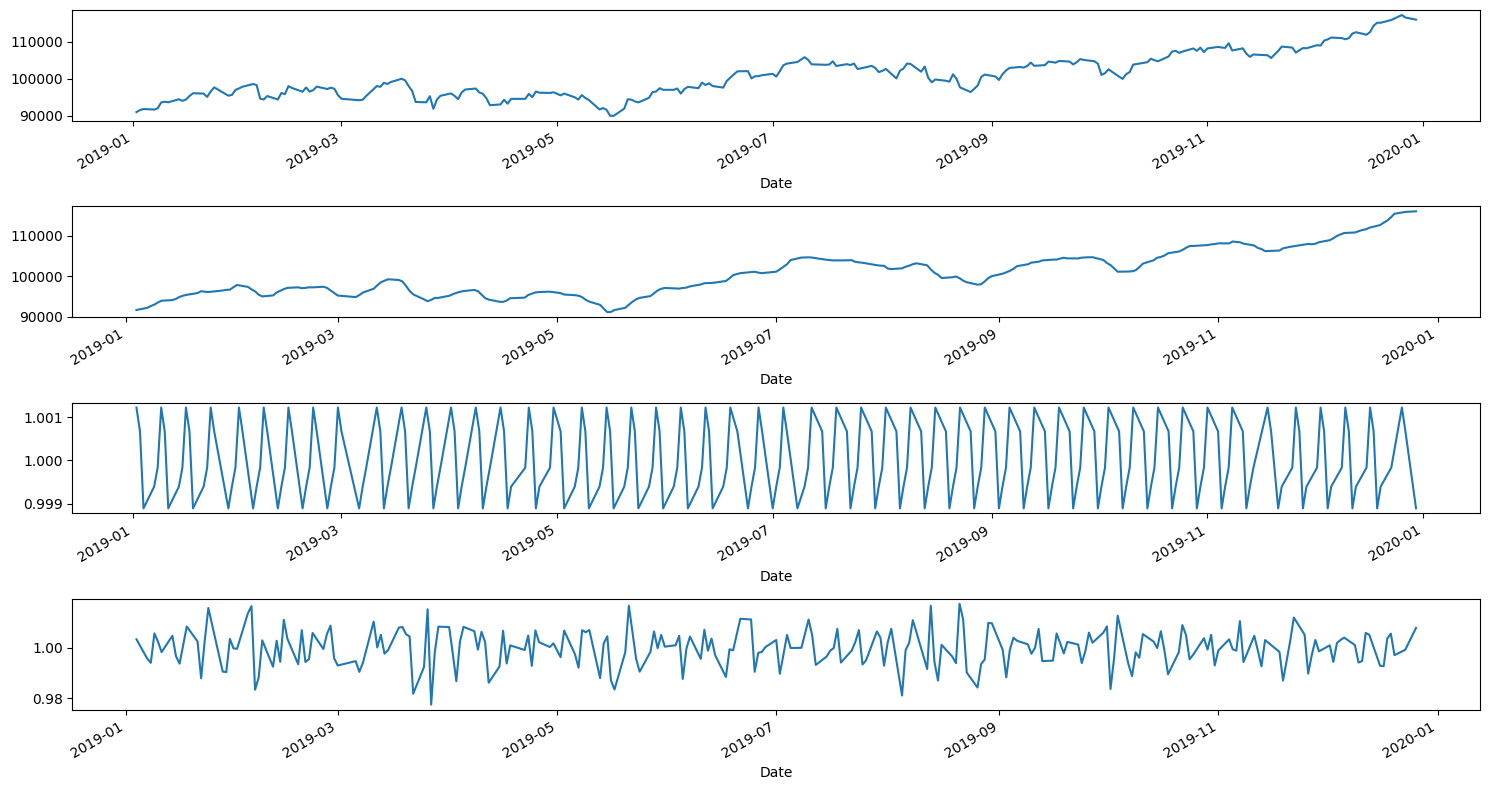

In [10]:
# Aqui a decomposição foi realizada no ano de 2019

df_limpo = df.copy()  # cópia do dataframe
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])  # transformando em datetime
df_limpo = df_limpo.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'])  # Removendo colunas desnecessárias
df_limpo = df_limpo.set_index('Date')  # definindo data como índice

# Filtrando por datas desejadas (por exemplo, de '2022-01-01' a '2022-12-31')
data_inicio = '2019-01-01'
data_fim = '2019-12-31'
df_limpo_filtrado = df_limpo.loc[data_inicio:data_fim]

# Decomposição sazonal nos dados filtrados
seasonplot = seasonal_decompose(df_limpo_filtrado, model='multiplicative', period=5)

# Subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8))
seasonplot.observed.plot(ax=ax1)  # Série real
seasonplot.trend.plot(ax=ax2)     # Tendência
seasonplot.seasonal.plot(ax=ax3)  # Sazonalidade
seasonplot.resid.plot(ax=ax4)     # Resíduos
plt.tight_layout()

plt.show()

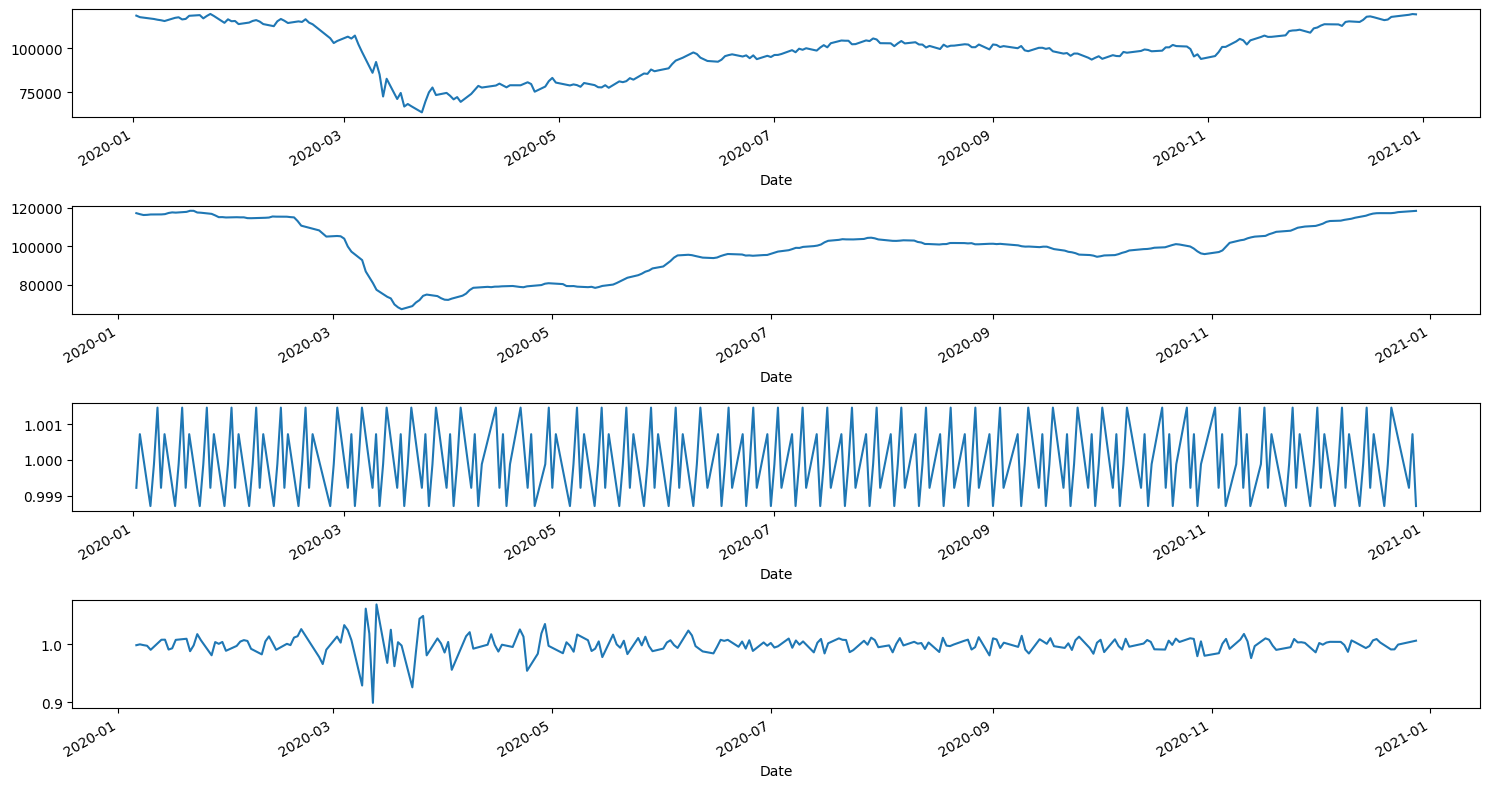

In [11]:
# Aqui a decomposição foi realizada no ano de 2020

df_limpo = df.copy()  # cópia do dataframe
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])  # transformando em datetime
df_limpo = df_limpo.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'])  # Removendo colunas desnecessárias
df_limpo = df_limpo.set_index('Date')  # definindo data como índice

# Filtrando por datas desejadas (por exemplo, de '2022-01-01' a '2022-12-31')
data_inicio = '2020-01-01'
data_fim = '2020-12-31'
df_limpo_filtrado = df_limpo.loc[data_inicio:data_fim]

# Decomposição sazonal nos dados filtrados
seasonplot = seasonal_decompose(df_limpo_filtrado, model='multiplicative', period=5)

# Subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8))
seasonplot.observed.plot(ax=ax1)  # Série real
seasonplot.trend.plot(ax=ax2)     # Tendência
seasonplot.seasonal.plot(ax=ax3)  # Sazonalidade
seasonplot.resid.plot(ax=ax4)     # Resíduos
plt.tight_layout()

plt.show()

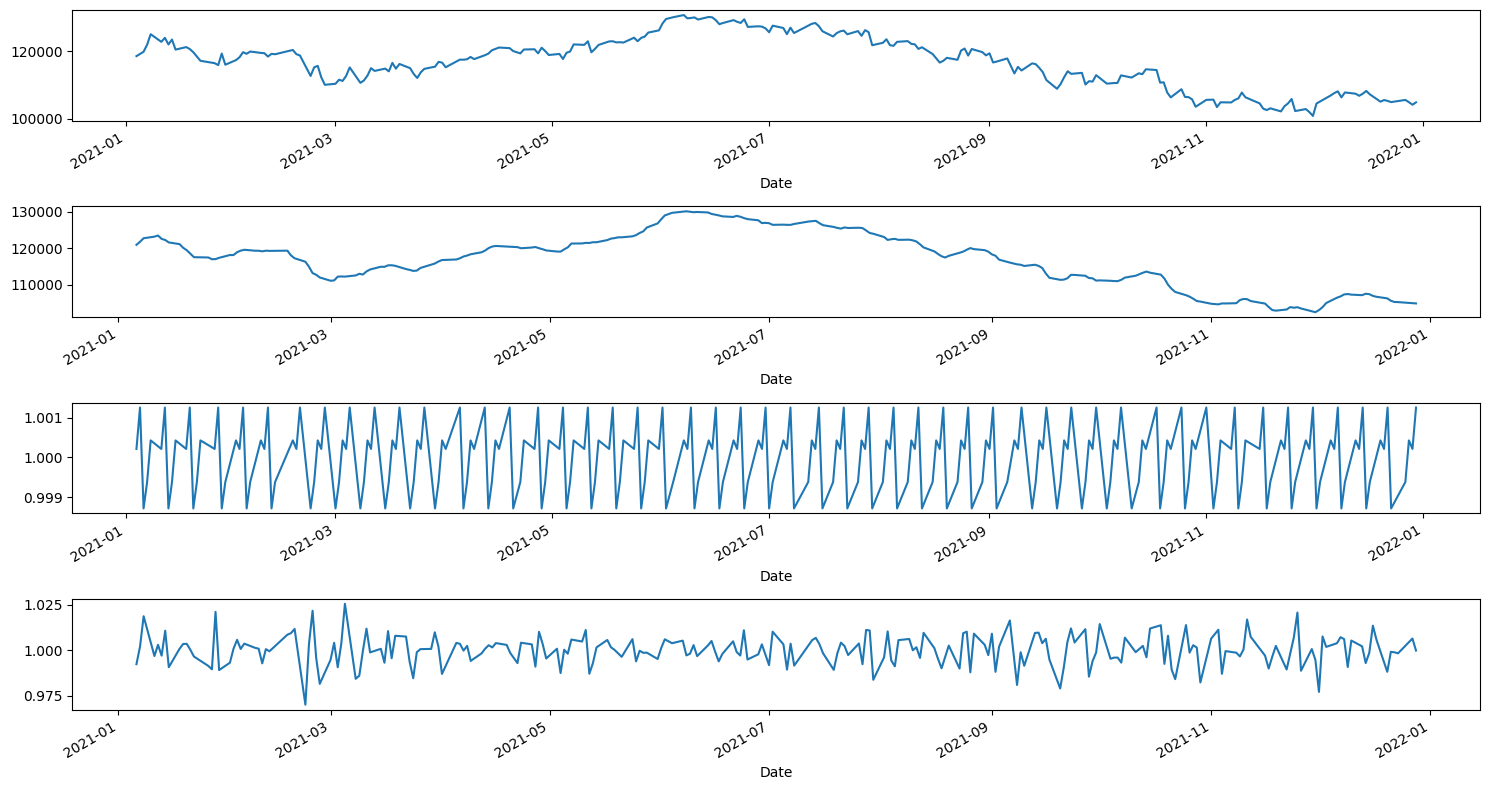

In [12]:
# Aqui a decomposição foi realizada no ano de 2021

df_limpo = df.copy()  # cópia do dataframe
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])  # transformando em datetime
df_limpo = df_limpo.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'])  # Removendo colunas desnecessárias
df_limpo = df_limpo.set_index('Date')  # definindo data como índice

# Filtrando por datas desejadas (por exemplo, de '2022-01-01' a '2022-12-31')
data_inicio = '2021-01-01'
data_fim = '2021-12-31'
df_limpo_filtrado = df_limpo.loc[data_inicio:data_fim]

# Decomposição sazonal nos dados filtrados
seasonplot = seasonal_decompose(df_limpo_filtrado, model='multiplicative', period=5)

# Subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8))
seasonplot.observed.plot(ax=ax1)  # Série real
seasonplot.trend.plot(ax=ax2)     # Tendência
seasonplot.seasonal.plot(ax=ax3)  # Sazonalidade
seasonplot.resid.plot(ax=ax4)     # Resíduos
plt.tight_layout()

plt.show()

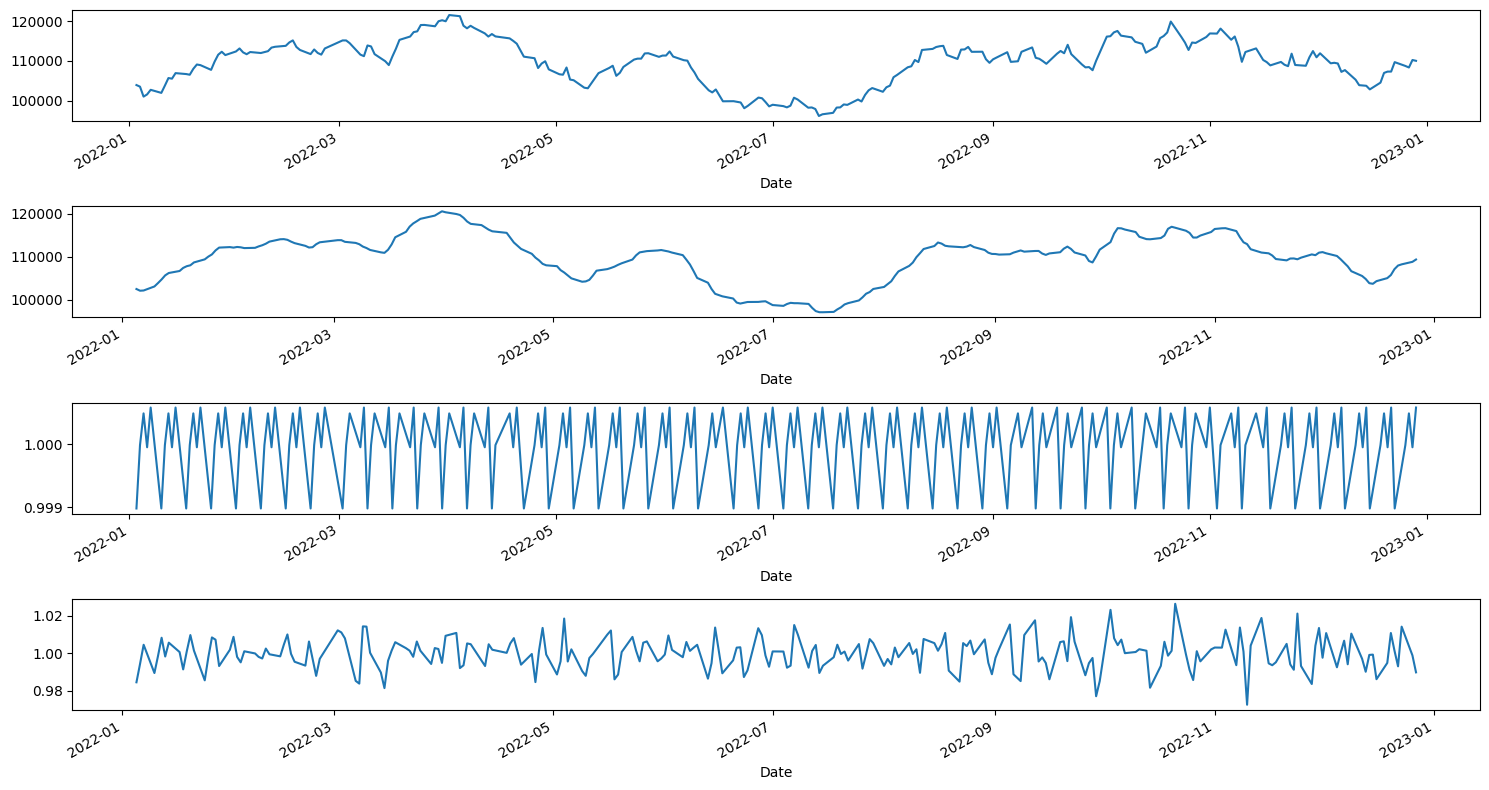

In [14]:
# Aqui a decomposição foi realizada no ano de 2022

df_limpo = df.copy()  # cópia do dataframe
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])  # transformando em datetime
df_limpo = df_limpo.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'])  # Removendo colunas desnecessárias
df_limpo = df_limpo.set_index('Date')  # definindo data como índice

# Filtrando por datas desejadas (por exemplo, de '2022-01-01' a '2022-12-31')
data_inicio = '2022-01-01'
data_fim = '2022-12-31'
df_limpo_filtrado = df_limpo.loc[data_inicio:data_fim]

# Decomposição sazonal nos dados filtrados
seasonplot = seasonal_decompose(df_limpo_filtrado, model='multiplicative', period=5)

# Subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8))
seasonplot.observed.plot(ax=ax1)  # Série real
seasonplot.trend.plot(ax=ax2)     # Tendência
seasonplot.seasonal.plot(ax=ax3)  # Sazonalidade
seasonplot.resid.plot(ax=ax4)     # Resíduos
plt.tight_layout()

plt.show()

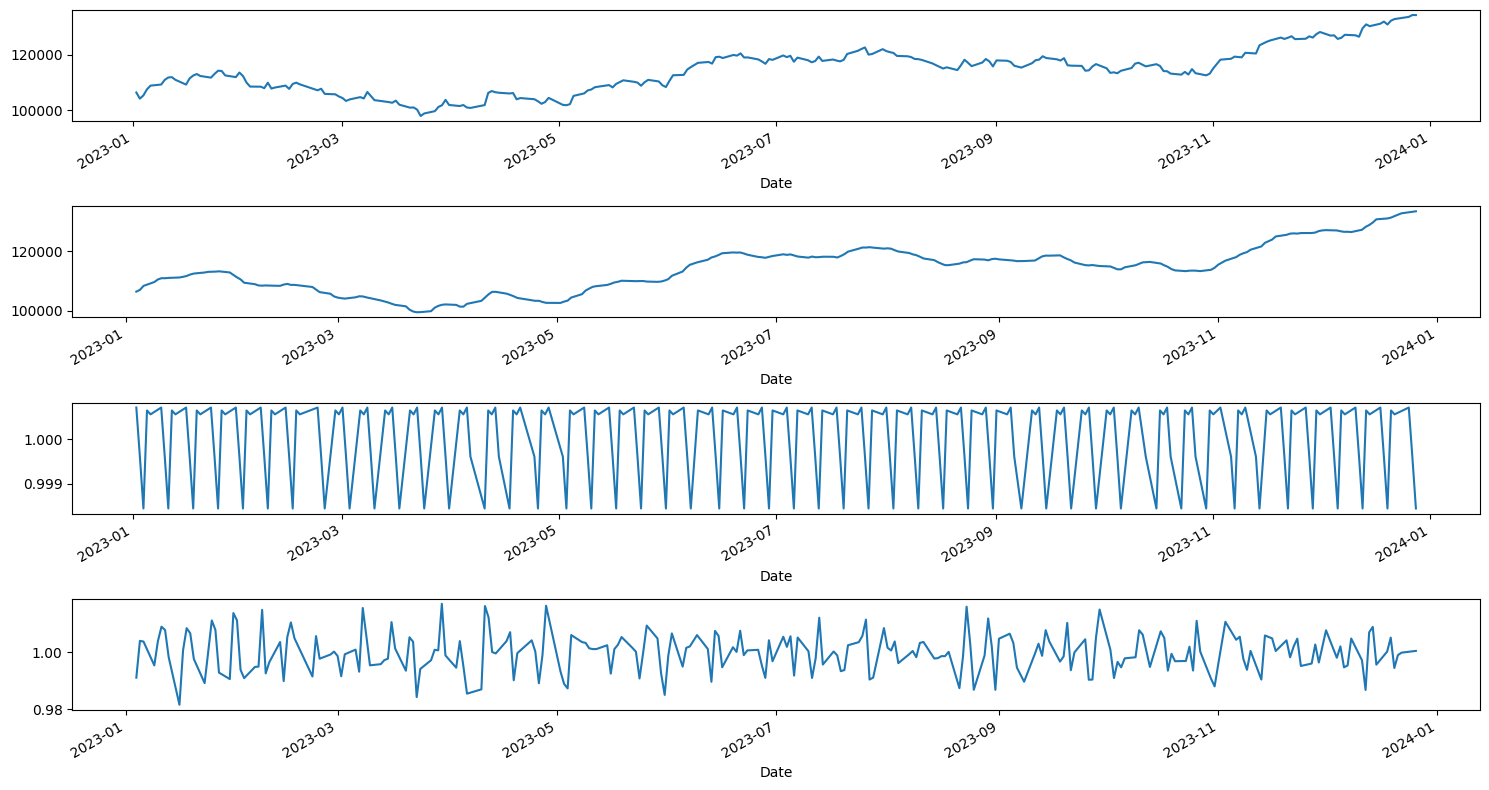

In [16]:
# Aqui a decomposição foi realizada no ano de 2023

df_limpo = df.copy()  # cópia do dataframe
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])  # transformando em datetime
df_limpo = df_limpo.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'])  # Removendo colunas desnecessárias
df_limpo = df_limpo.set_index('Date')  # definindo data como índice

# Filtrando por datas desejadas (por exemplo, de '2022-01-01' a '2022-12-31')
data_inicio = '2023-01-01'
data_fim = '2023-12-31'
df_limpo_filtrado = df_limpo.loc[data_inicio:data_fim]

# Decomposição sazonal nos dados filtrados
seasonplot = seasonal_decompose(df_limpo_filtrado, model='multiplicative', period=5)

# Subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8))
seasonplot.observed.plot(ax=ax1)  # Série real
seasonplot.trend.plot(ax=ax2)     # Tendência
seasonplot.seasonal.plot(ax=ax3)  # Sazonalidade
seasonplot.resid.plot(ax=ax4)     # Resíduos
plt.tight_layout()

plt.show()

Notei que na maioria dos gráficos, em maio o grafico cai e começa a subir depois de Julho

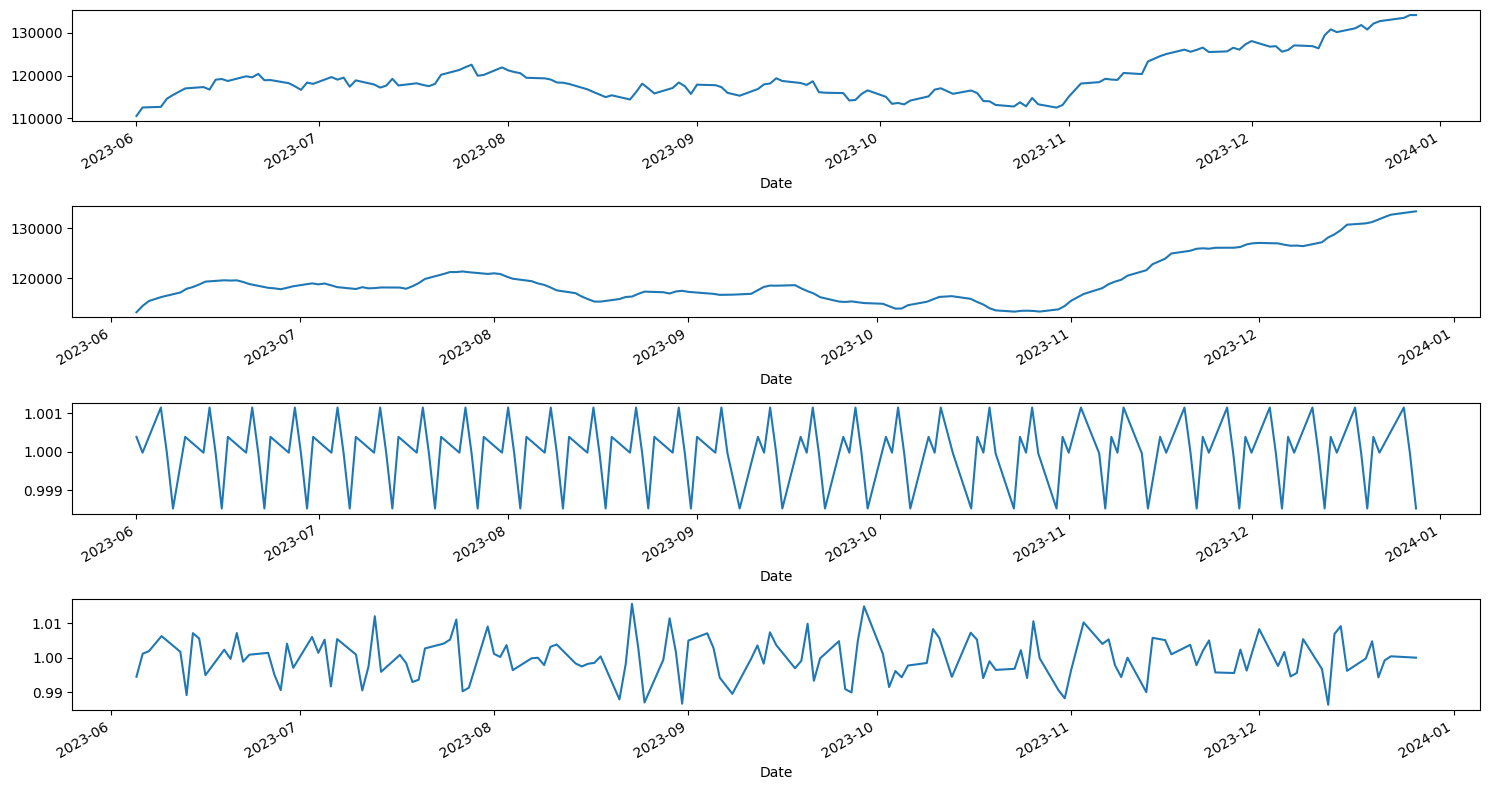

In [20]:
# Aqui a decomposição foi realizada no segundo semestre de 2023

df_limpo = df.copy()  # cópia do dataframe
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])  # transformando em datetime
df_limpo = df_limpo.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'])  # Removendo colunas desnecessárias
df_limpo = df_limpo.set_index('Date')  # definindo data como índice

# Filtrando por datas desejadas (por exemplo, de '2022-01-01' a '2022-12-31')
data_inicio = '2023-06-01'
data_fim = '2023-12-31'
df_limpo_filtrado = df_limpo.loc[data_inicio:data_fim]

# Decomposição sazonal nos dados filtrados
seasonplot = seasonal_decompose(df_limpo_filtrado, model='multiplicative', period=5)

# Subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8))
seasonplot.observed.plot(ax=ax1)  # Série real
seasonplot.trend.plot(ax=ax2)     # Tendência
seasonplot.seasonal.plot(ax=ax3)  # Sazonalidade
seasonplot.resid.plot(ax=ax4)     # Resíduos
plt.tight_layout()

plt.show()

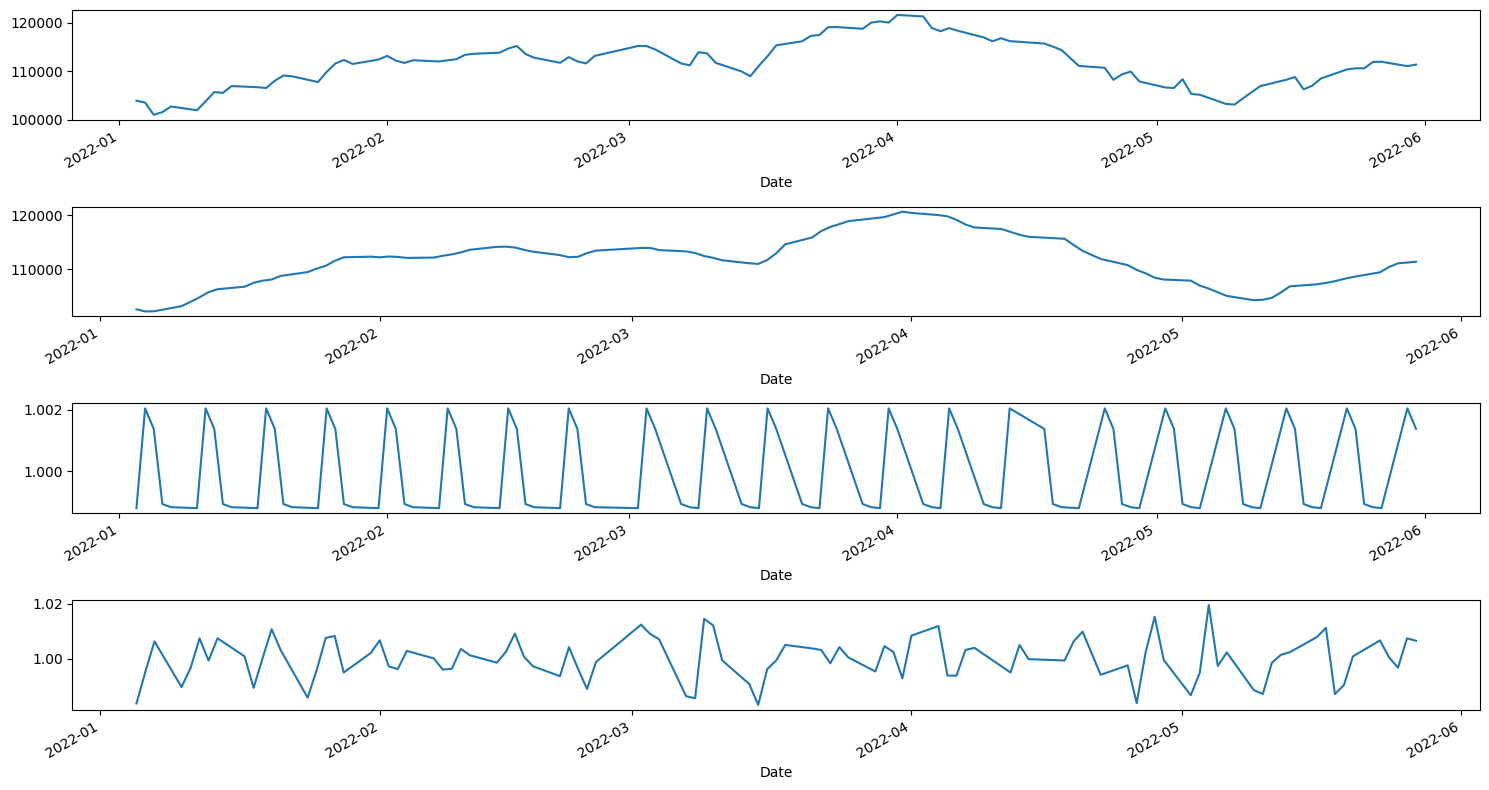

In [21]:
# Aqui a decomposição foi realizada em ...

df_limpo = df.copy()  # cópia do dataframe
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])  # transformando em datetime
df_limpo = df_limpo.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'])  # Removendo colunas desnecessárias
df_limpo = df_limpo.set_index('Date')  # definindo data como índice

# Filtrando por datas desejadas (por exemplo, de '2022-01-01' a '2022-12-31')
data_inicio = '2022-01-01'
data_fim = '2022-05-31'
df_limpo_filtrado = df_limpo.loc[data_inicio:data_fim]

# Decomposição sazonal nos dados filtrados
seasonplot = seasonal_decompose(df_limpo_filtrado, model='multiplicative', period=5)

# Subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8))
seasonplot.observed.plot(ax=ax1)  # Série real
seasonplot.trend.plot(ax=ax2)     # Tendência
seasonplot.seasonal.plot(ax=ax3)  # Sazonalidade
seasonplot.resid.plot(ax=ax4)     # Resíduos
plt.tight_layout()

plt.show()

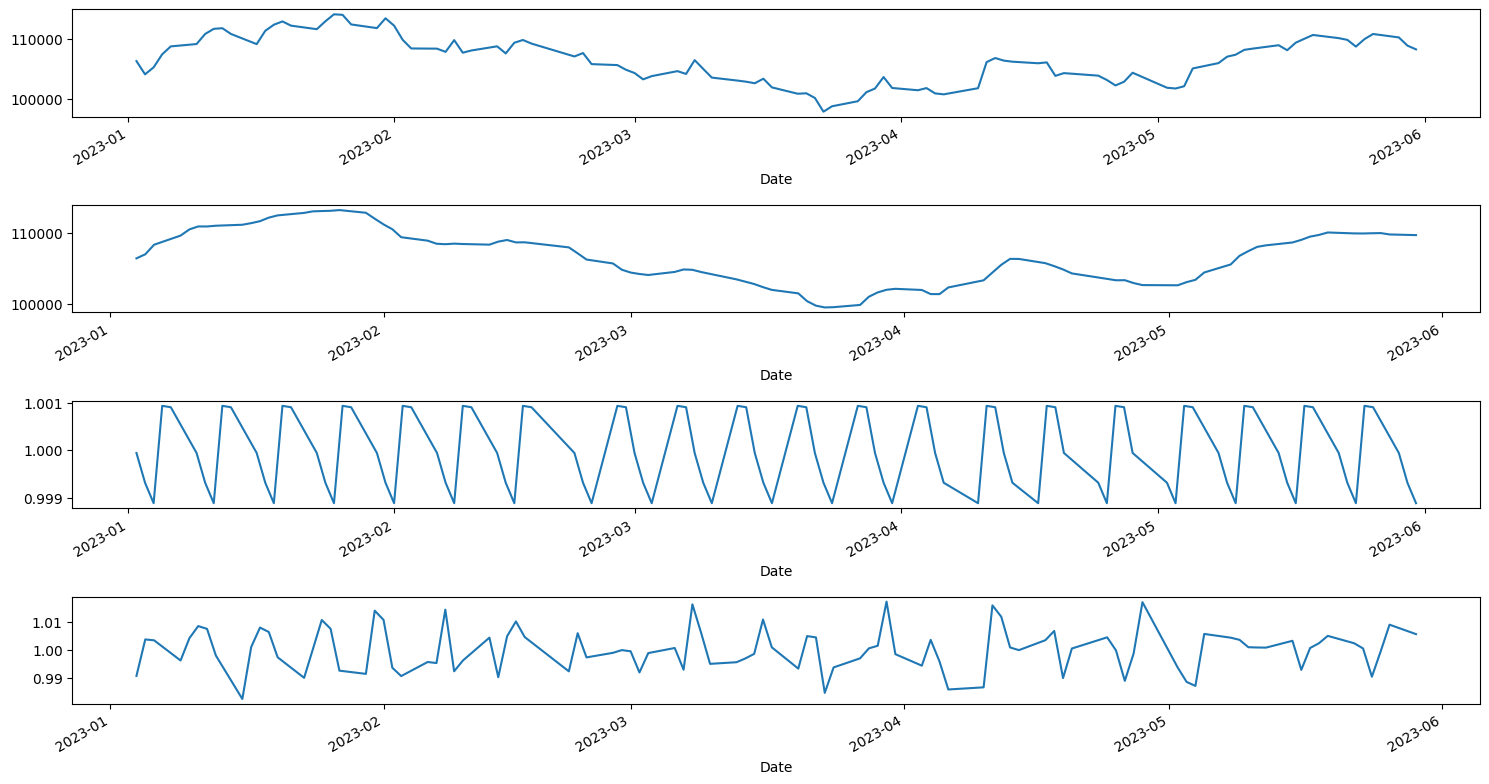

In [22]:
# Aqui a decomposição foi realizada em ...

df_limpo = df.copy()  # cópia do dataframe
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])  # transformando em datetime
df_limpo = df_limpo.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'])  # Removendo colunas desnecessárias
df_limpo = df_limpo.set_index('Date')  # definindo data como índice

# Filtrando por datas desejadas (por exemplo, de '2022-01-01' a '2022-12-31')
data_inicio = '2023-01-01'
data_fim = '2023-05-31'
df_limpo_filtrado = df_limpo.loc[data_inicio:data_fim]

# Decomposição sazonal nos dados filtrados
seasonplot = seasonal_decompose(df_limpo_filtrado, model='multiplicative', period=5)

# Subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8))
seasonplot.observed.plot(ax=ax1)  # Série real
seasonplot.trend.plot(ax=ax2)     # Tendência
seasonplot.seasonal.plot(ax=ax3)  # Sazonalidade
seasonplot.resid.plot(ax=ax4)     # Resíduos
plt.tight_layout()

plt.show()